<a href="https://colab.research.google.com/github/swilsonmfc/linear/blob/main/Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regularization

![](https://shoefer.github.io/intuitivemi/images/2015-08-07-overfitting-sizeprice.png)


# Setup

In [1]:
import math
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling

from sklearn.datasets import load_boston
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.pipeline import make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError

import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
import statsmodels.graphics.regressionplots as regplot
from statsmodels.stats.outliers_influence import variance_inflation_factor

from patsy import dmatrices

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
%matplotlib inline

# Data

In [3]:
boston = load_boston()
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [4]:
bostonDF = pd.DataFrame(boston['data'], columns=boston['feature_names'])
bostonDF['TARGET'] = boston['target']
bostonDF.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


## Categorical

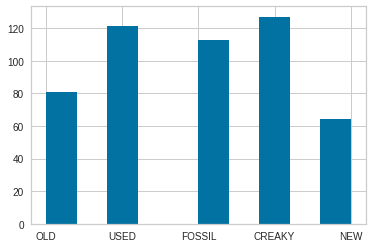

In [5]:
def ageBin(age):
    if age < 30: return 'NEW'
    if age < 60: return 'USED'
    if age < 80: return 'OLD'
    if age < 95: return 'CREAKY'
    return 'FOSSIL'
bostonDF['AGE_BIN'] = bostonDF['AGE'].apply(ageBin)
bostonDF['AGE_BIN'].hist()

## EDA

In [6]:
bostonDF

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET,AGE_BIN
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0,OLD
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6,OLD
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7,OLD
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4,USED
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2,USED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4,OLD
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6,OLD
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9,CREAKY
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0,CREAKY


In [7]:
bostonDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 15 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  TARGET   506 non-null    float64
 14  AGE_BIN  506 non-null    object 
dtypes: float64(14), object(1)
memory usage: 59.4+ KB


In [8]:
bostonDF.memory_usage(deep=True)

Index        128
CRIM        4048
ZN          4048
INDUS       4048
CHAS        4048
NOX         4048
RM          4048
AGE         4048
DIS         4048
RAD         4048
TAX         4048
PTRATIO     4048
B           4048
LSTAT       4048
TARGET      4048
AGE_BIN    42661
dtype: int64

# Preprocessing

In [9]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)

        try:
            return X[self.columns]
        except KeyError:
            cols_error = list(set(self.columns) - set(X.columns))
            raise KeyError("The DataFrame does not include the columns: %s" % cols_error)


class TypeSelector(BaseEstimator, TransformerMixin):
    def __init__(self, dtype):
        self.dtype = dtype

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        assert isinstance(X, pd.DataFrame)
        return X.select_dtypes(include=[self.dtype])

In [10]:
bostonDF['AGE_BIN'] = bostonDF['AGE_BIN'].astype('category')
bostonDF = bostonDF.drop('AGE', axis=1)

In [11]:
process = make_pipeline(
    FeatureUnion(transformer_list=[
        ("numeric_features", make_pipeline(
            TypeSelector(np.number),
            StandardScaler()
        )),
        ("categorical_features", make_pipeline(
            TypeSelector("category"),
            OneHotEncoder(categories='auto', drop='first')
        ))
    ])
)


# Model

## Tracking

In [12]:
resultsDF = pd.DataFrame(columns=['MAE', 'MSE', 'RMSE'])
compareDF = pd.DataFrame()

## Fit

In [13]:
df = bostonDF.copy()
y = df['TARGET']
X = df.drop('TARGET', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

clf = LinearRegression()
pipe = Pipeline(steps=[('process', process), ('regression', clf)])
pipe.fit(X_train, y_train)

pred = pipe.predict(X_test)
mae  = mean_absolute_error(y_test, pred)
mse  = mean_squared_error(y_test, pred)
rmse = math.sqrt(mse)

print('MAE  = {:.2f}'.format(mae))
print('MSE  = {:.2f}'.format(mse))
print('RMSE = {:.2f}'.format(rmse))

resultsDF.loc['OLS'] = [mae, mse, rmse]
compareDF = pd.concat([compareDF, pd.DataFrame(clf.coef_)], axis=1)

MAE  = 3.26
MSE  = 23.35
RMSE = 4.83


# Regularization
Adding features to Linear Regression will always have the effect of improving R-Squared.  To mitigate the chance of overfitting (fitting noise in the data) we want to penalize higher larger coefficients using L1 or L2 Norms.  The choice of L1 or L2 has an important effect.

## Norms
* Norm is the length of all vectors in a space
* L1 Norm
 * Manhattan Distance
 * Sum of absolute values of coefficients
* L2 Norm
 * Euclidean Distance
 * Sum of squared coefficients
* L1 and / or L2 are added to the cost function
 * Large coefficients result in higher penalty

![](https://qph.fs.quoracdn.net/main-qimg-4487048edfabdb1b039c854042ba376b.webp)

# Lasso - L1 Regularization

![](https://www.analyticsvidhya.com/wp-content/uploads/2016/01/eq8-1.png)

## Model

In [14]:
df = bostonDF.copy()
y = df['TARGET']
X = df.drop('TARGET', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

clf = Lasso()
pipe = Pipeline(steps=[('process', process), ('regression', clf)])
pipe.fit(X_train, y_train)

pred = pipe.predict(X_test)
mae  = mean_absolute_error(y_test, pred)
mse  = mean_squared_error(y_test, pred)
rmse = math.sqrt(mse)

print('MAE  = {:.2f}'.format(mae))
print('MSE  = {:.2f}'.format(mse))
print('RMSE = {:.2f}'.format(rmse))
resultsDF.loc['Lasso'] = [mae, mse, rmse]
compareDF = pd.concat([compareDF, pd.DataFrame(clf.coef_)], axis=1)

MAE  = 3.85
MSE  = 33.71
RMSE = 5.81


## Alpha Hyperparameter

In [15]:
hyperDF = pd.DataFrame()
alpha = [0.0, 0.05, 0.25, 0.5, 0.75, 1.0]
cols  = []
for a in alpha:
    col = 'Alpha-{}'.format(a)
    clf = Lasso(alpha=a)
    pipe = Pipeline(steps=[('process', process), ('regression', clf)])
    pipe.fit(X_train, y_train)
    hyperDF[col] = clf.coef_
hyperDF = hyperDF.sort_values('Alpha-0.0')

/usr/local/lib/python3.6/dist-packages/sklearn/pipeline.py:354: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:460: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4328.70008603678, tolerance: 3.42309674009901
  max_iter, tol, rng, random, positive)


Text(0.5, 1.0, 'Lasso - Alpha 1.0')

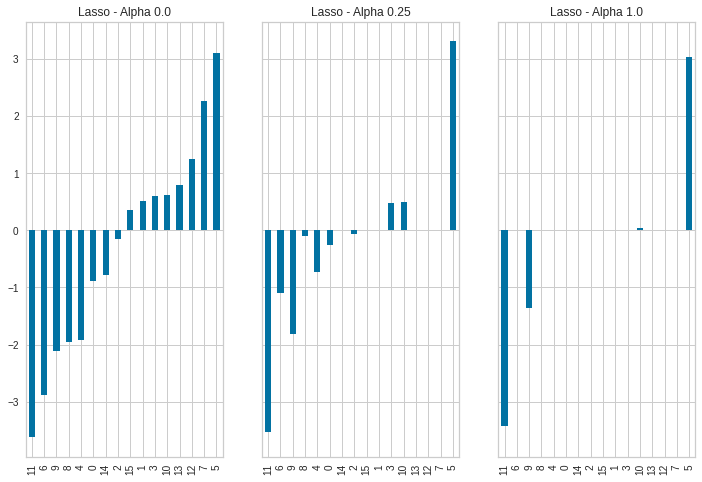

In [16]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,8), sharey=True)
ax1 = hyperDF['Alpha-0.0'].plot.bar(ax=ax1)
ax1.set_title('Lasso - Alpha 0.0')
ax2 = hyperDF['Alpha-0.25'].plot.bar(ax=ax2)
ax2.set_title('Lasso - Alpha 0.25')
ax3 = hyperDF['Alpha-1.0'].plot.bar(ax=ax3)
ax3.set_title('Lasso - Alpha 1.0')

# Ridge - L2 Regularization

![](https://www.analyticsvidhya.com/wp-content/uploads/2016/01/eq5-1.png)

## Model

In [17]:
df = bostonDF.copy()
y = df['TARGET']
X = df.drop('TARGET', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

clf = Ridge()
pipe = Pipeline(steps=[('process', process), ('regression', clf)])
pipe.fit(X_train, y_train)

pred = pipe.predict(X_test)
mae  = mean_absolute_error(y_test, pred)
mse  = mean_squared_error(y_test, pred)
rmse = math.sqrt(mse)

print('MAE  = {:.2f}'.format(mae))
print('MSE  = {:.2f}'.format(mse))
print('RMSE = {:.2f}'.format(rmse))
resultsDF.loc['Ridge'] = [mae, mse, rmse]
compareDF = pd.concat([compareDF, pd.DataFrame(clf.coef_)], axis=1)

MAE  = 3.25
MSE  = 23.40
RMSE = 4.84


## Alpha Hyperparameter

In [18]:
hyperDF = pd.DataFrame()
alpha = [0.0, 0.05, 0.25, 0.5, 0.75, 1.0, 500.0]
cols  = []
for a in alpha:
    col = 'Ridge-{}'.format(a)
    clf = Ridge(alpha=a)
    pipe = Pipeline(steps=[('process', process), ('regression', clf)])
    pipe.fit(X_train, y_train)
    hyperDF[col] = clf.coef_
hyperDF = hyperDF.sort_values('Ridge-0.0')

Text(0.5, 1.0, 'Ridge - Alpha 500.0')

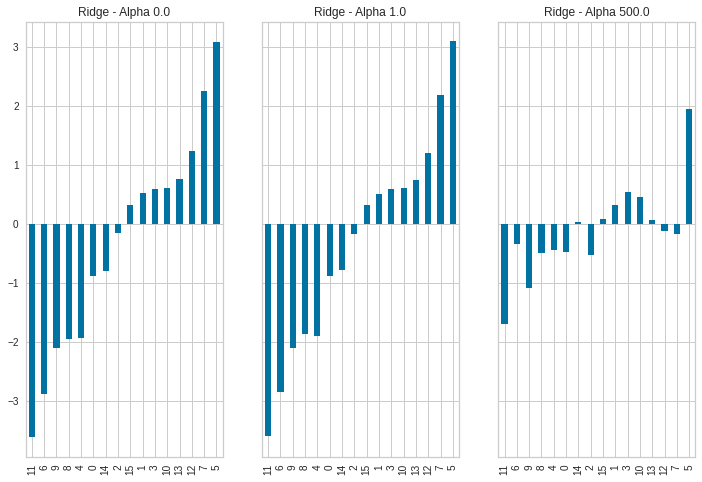

In [19]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,8), sharey=True)
ax1 = hyperDF['Ridge-0.0'].plot.bar(ax=ax1)
ax1.set_title('Ridge - Alpha 0.0')
ax2 = hyperDF['Ridge-1.0'].plot.bar(ax=ax2)
ax2.set_title('Ridge - Alpha 1.0')
ax3 = hyperDF['Ridge-500.0'].plot.bar(ax=ax3)
ax3.set_title('Ridge - Alpha 500.0')

# Ridge vs Lasso
* Lasso moves several exogenous variables to 0.0

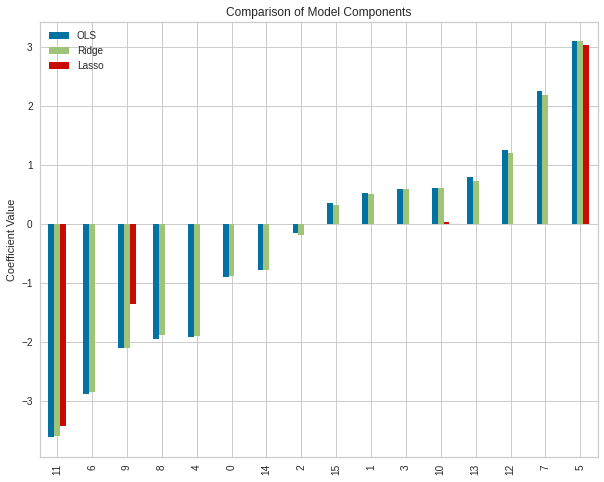

In [20]:
fig, ax = plt.subplots(figsize=(10,8))
compareDF.columns = ['OLS', 'Lasso', 'Ridge']
compareDF = compareDF.sort_values('OLS')
plt.title('Comparison of Model Components')
plt.ylabel('Coefficient Value')
compareDF[['OLS', 'Ridge', 'Lasso']].plot.bar(ax=ax)

# ElasticNet - Lasso + Ridge

In [21]:
df = bostonDF.copy()
y = df['TARGET']
X = df.drop('TARGET', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1337)

for l1 in np.arange(0.1, 1, 0.1):
    clf = ElasticNet(l1_ratio=l1)
    pipe = Pipeline(steps=[('process', process), ('regression', clf)])
    pipe.fit(X_train, y_train)

    pred = pipe.predict(X_test)
    mae  = mean_absolute_error(y_test, pred)
    mse  = mean_squared_error(y_test, pred)
    rmse = math.sqrt(mse)
    classifier = 'ElasticNet - L1={:.1f}  L2={:.1f}'.format(l1, 1.0 - l1)
    print ('{} MAE {:.3f} MSE {:.3f} RMSE {:.3f}'.format(classifier, mae, mse, rmse))
    resultsDF.loc[classifier] = [mae, mse, rmse]

ElasticNet - L1=0.1  L2=0.9 MAE 4.002 MSE 34.194 RMSE 5.848
ElasticNet - L1=0.2  L2=0.8 MAE 3.977 MSE 34.130 RMSE 5.842
ElasticNet - L1=0.3  L2=0.7 MAE 3.965 MSE 34.183 RMSE 5.847
ElasticNet - L1=0.4  L2=0.6 MAE 3.970 MSE 34.387 RMSE 5.864
ElasticNet - L1=0.5  L2=0.5 MAE 3.953 MSE 34.248 RMSE 5.852
ElasticNet - L1=0.6  L2=0.4 MAE 3.928 MSE 34.032 RMSE 5.834
ElasticNet - L1=0.7  L2=0.3 MAE 3.901 MSE 33.865 RMSE 5.819
ElasticNet - L1=0.8  L2=0.2 MAE 3.883 MSE 33.758 RMSE 5.810
ElasticNet - L1=0.9  L2=0.1 MAE 3.867 MSE 33.772 RMSE 5.811


# Comparison
* ElasticNet L1 = 1.0 == Lasso
* ElasticNet L2 = 1.0 == Ridge (Warning unsable l1_ratio < 0.01)
* Lasso or Ridge with Alpha = 0.0 == OLS

## Top by RMSE

In [22]:
resultsDF.sort_values('RMSE')

,MAE,MSE,RMSE
OLS,3.255763,23.348944,4.832074
Ridge,3.252144,23.397840,4.837131
Lasso,3.850945,33.710895,5.806108
ElasticNet - L1=0.8 L2=0.2,3.883378,33.758333,5.810192
ElasticNet - L1=0.9 L2=0.1,3.866774,33.771558,5.811330
ElasticNet - L1=0.7 L2=0.3,3.900804,33.864504,5.819322
ElasticNet - L1=0.6 L2=0.4,3.927706,34.031639,5.833664
ElasticNet - L1=0.2 L2=0.8,3.977364,34.130092,5.842097
ElasticNet - L1=0.3 L2=0.7,3.965379,34.183209,5.846641
ElasticNet - L1=0.1 L2=0.9,4.002250,34.193813,5.847548


## Top by MAE

In [23]:
resultsDF.sort_values('MAE')

,MAE,MSE,RMSE
Ridge,3.252144,23.397840,4.837131
OLS,3.255763,23.348944,4.832074
Lasso,3.850945,33.710895,5.806108
ElasticNet - L1=0.9 L2=0.1,3.866774,33.771558,5.811330
ElasticNet - L1=0.8 L2=0.2,3.883378,33.758333,5.810192
ElasticNet - L1=0.7 L2=0.3,3.900804,33.864504,5.819322
ElasticNet - L1=0.6 L2=0.4,3.927706,34.031639,5.833664
ElasticNet - L1=0.5 L2=0.5,3.952527,34.247912,5.852172
ElasticNet - L1=0.3 L2=0.7,3.965379,34.183209,5.846641
ElasticNet - L1=0.4 L2=0.6,3.970090,34.387110,5.864052


# Notes
* Consider regularization as a default for predicting Linear Models
 * Ridge promotes coefficients close to zero
 * Lasso promotes sparsity and can be used for feature selection
 * In this example, Lasso kept 3 - 4 non-zero features + Intercept
 * Ridge kept all features 
 * Lasso / Ridge can change coefficients quite dramatically (positive to negative) with different levels of alpha
* Remember Assumptions
 * LINE
 * Inspect Residuals & Prediction Plots
 * Look for High Leverage Points
* Produce multiple metrics 
 * Remember differences between MAE & RMSE
 * R-Squared is intuitive but limited
* Stick to SKlearn if your objective is highest accuracy.
 * Easy to swap in / out estimators
 * Pipeline support is helpful
* Consider Statsmodel / R if you're modeling Linear Regression and want deep explanatory capabaility
 * Statsmodel has support for Lasso / Risge with .fit_regularized (0 <= L1_wt <= 1)  